# Training

In [1]:
import torch
import random
import numpy as np

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data

from transforms import train_transforms, val_transforms
from dataset import ContrastiveLearningDataset, SimpleDataset

## Loading data

In [2]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [3]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


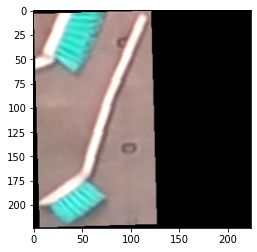

In [4]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [5]:
images = df['img']
labels = df['category_id']

val_labels = [1, 2, 3]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [6]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)
val_dataset = SimpleDataset(train_images, train_labels, val_transforms)

In [7]:
id_ = random.randrange(0, len(train_dataset))

image, label = train_dataset[id_]

# f, axarr = plt.subplots(1,2) 

# axarr[0].imshow(image_1.permute(1, 2, 0))
# axarr[1].imshow(image_2.permute(1, 2, 0))

# sign, weight

print(image.mean(), image.max(), image.min())

tensor(0.1358) tensor(0.9216) tensor(0.)


In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [9]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=False,
)

## Training loop

In [10]:
EPOCHS = 100

In [11]:
from model import ImageEmbeddingModel

In [12]:
out_dim=32

model = ImageEmbeddingModel(out_dim=out_dim, efficientnet_model_name="efficientnet-b0").to(device=DEVICE)
# optimizer = torch.optim.Adam(model.get_last_params())
optimizer = torch.optim.Adam(model.get_last_params())

Loaded pretrained weights for efficientnet-b0


In [13]:
from losses import ContrastiveLoss, CosineSimilarityLoss

loss_function = CosineSimilarityLoss(pos_weight=3)
# loss_function = ContrastiveLoss(np.sqrt(out_dim))
# loss_function2 = ContrastiveLoss(np.sqrt(out_dim), reduction="NONE")
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# def contrastive_learning_loss(v_1, v_2, weight, sign):
#     cos_sim = cos(v_1, v_2)
#     loss = - weight * cos_sim * sign
#     return loss.mean()



In [14]:

from sklearn.decomposition import PCA

def validate(model, dataset):
    embeddings = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.to(device=DEVICE).unsqueeze(0)
        label = label
        emb = model(image)
        embeddings.append(emb[0].detach().cpu().numpy())
        labels.append(label)

    emb4lab_dict = {}
    for e, l in zip(embeddings, labels):
        if l not in emb4lab_dict.keys():
            emb4lab_dict[l] = [e]
        else:
            emb4lab_dict[l].append(e)
    for l in emb4lab_dict.keys():
        emb4lab_dict[l] = np.mean(np.array(emb4lab_dict[l]), axis=0)
    
    lbl_dsts = {}
    for e, l in zip(embeddings, labels):
        dst = np.sum(np.abs(e - emb4lab_dict[l]))
        if l not in lbl_dsts.keys():
            lbl_dsts[l] = [dst]
        else:
            lbl_dsts[l].append(dst)
    for l in lbl_dsts.keys():
        lbl_dsts[l] = np.mean(np.array(lbl_dsts[l]), axis=0)
        print(f"LABEL: {l} - MEAN DST: {lbl_dsts[l]}")
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    pca = PCA()
    pca.fit(embeddings)
    emb2d = pca.transform(embeddings)
    plt.scatter(emb2d[:,0], emb2d[:,1], c=labels)
    plt.show()

LABEL: 1 - MEAN DST: 4.166038513183594
LABEL: 2 - MEAN DST: 4.059195518493652
LABEL: 3 - MEAN DST: 4.227926731109619


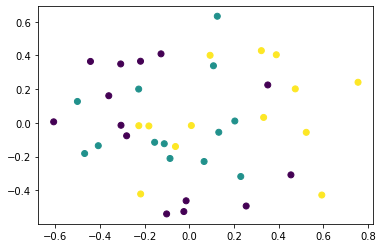

Epoch: 1/100: Loss: -1.5314604043960571
LABEL: 1 - MEAN DST: 2.5003256797790527
LABEL: 2 - MEAN DST: 2.375291347503662
LABEL: 3 - MEAN DST: 1.9101580381393433


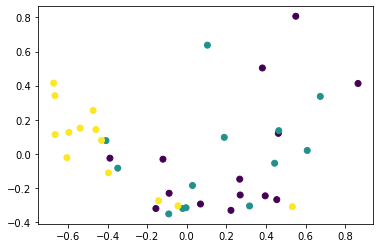

Epoch: 2/100: Loss: -5.76192831993103
Epoch: 3/100: Loss: -8.628479957580566
Epoch: 4/100: Loss: -10.651245594024658
Epoch: 5/100: Loss: -9.995484352111816
Epoch: 6/100: Loss: -11.556211948394775
LABEL: 1 - MEAN DST: 1.137638807296753
LABEL: 2 - MEAN DST: 1.007960557937622
LABEL: 3 - MEAN DST: 3.7025604248046875


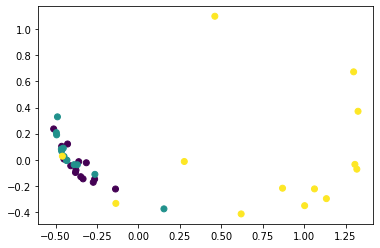

Epoch: 7/100: Loss: -11.447919845581055
Epoch: 8/100: Loss: -11.112706661224365
Epoch: 9/100: Loss: -11.680996894836426
Epoch: 10/100: Loss: -11.729467868804932
Epoch: 11/100: Loss: -11.764573574066162
LABEL: 1 - MEAN DST: 0.5657153725624084
LABEL: 2 - MEAN DST: 0.609431266784668
LABEL: 3 - MEAN DST: 3.884347438812256


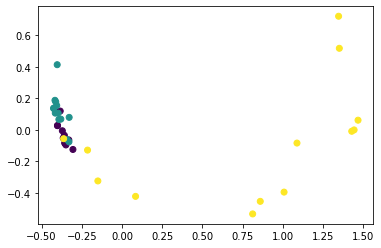

Epoch: 12/100: Loss: -11.382267475128174
Epoch: 13/100: Loss: -10.036680936813354
Epoch: 14/100: Loss: -11.895938396453857
Epoch: 15/100: Loss: -11.615827560424805
Epoch: 16/100: Loss: -9.898450374603271
LABEL: 1 - MEAN DST: 0.629634439945221
LABEL: 2 - MEAN DST: 0.9581114649772644
LABEL: 3 - MEAN DST: 2.959376811981201


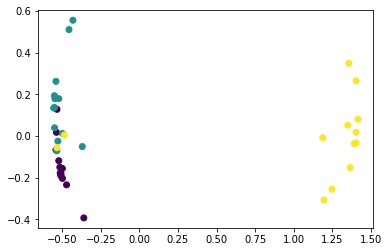

Epoch: 17/100: Loss: -11.416082382202148
Epoch: 18/100: Loss: -10.53018307685852
Epoch: 19/100: Loss: -11.636733531951904
Epoch: 20/100: Loss: -12.205734729766846
Epoch: 21/100: Loss: -12.148518085479736
LABEL: 1 - MEAN DST: 1.4191416501998901
LABEL: 2 - MEAN DST: 4.217558860778809
LABEL: 3 - MEAN DST: 1.1605719327926636


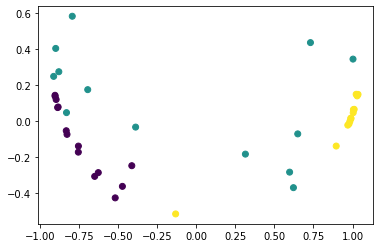

Epoch: 22/100: Loss: -12.136553764343262
Epoch: 23/100: Loss: -12.754025936126709
Epoch: 24/100: Loss: -13.161251068115234
Epoch: 25/100: Loss: -12.155205726623535
Epoch: 26/100: Loss: -12.369810104370117
LABEL: 1 - MEAN DST: 1.3545753955841064
LABEL: 2 - MEAN DST: 2.5567660331726074
LABEL: 3 - MEAN DST: 1.3398493528366089


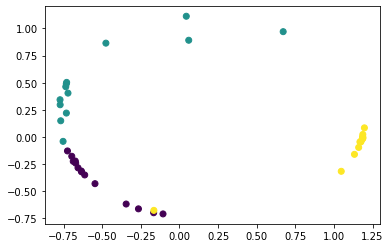

Epoch: 27/100: Loss: -12.133488178253174
Epoch: 28/100: Loss: -12.288028717041016
Epoch: 29/100: Loss: -12.818053722381592
Epoch: 30/100: Loss: -12.565292358398438
Epoch: 31/100: Loss: -12.740060806274414
LABEL: 1 - MEAN DST: 1.058229923248291
LABEL: 2 - MEAN DST: 1.9286695718765259
LABEL: 3 - MEAN DST: 1.0503695011138916


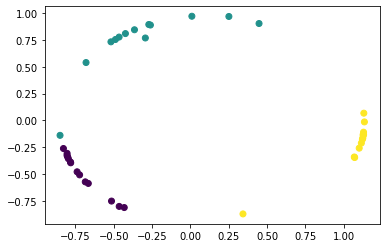

Epoch: 32/100: Loss: -13.266494274139404
Epoch: 33/100: Loss: -11.691753387451172
Epoch: 34/100: Loss: -13.057690143585205
Epoch: 35/100: Loss: -12.470548629760742
Epoch: 36/100: Loss: -12.434491634368896
LABEL: 1 - MEAN DST: 1.6135685443878174
LABEL: 2 - MEAN DST: 1.5179486274719238
LABEL: 3 - MEAN DST: 1.2007304430007935


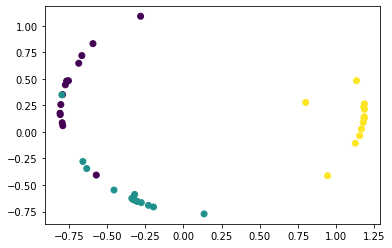

Epoch: 37/100: Loss: -11.420965671539307
Epoch: 38/100: Loss: -12.14081621170044
Epoch: 39/100: Loss: -12.245235443115234
Epoch: 40/100: Loss: -12.033617496490479
Epoch: 41/100: Loss: -11.464871883392334
LABEL: 1 - MEAN DST: 1.234545111656189
LABEL: 2 - MEAN DST: 2.102620840072632
LABEL: 3 - MEAN DST: 1.873197317123413


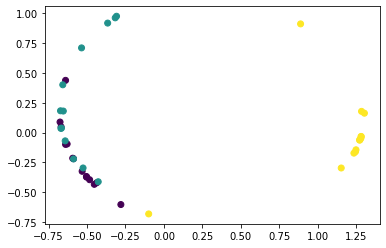

Epoch: 42/100: Loss: -12.622559070587158
Epoch: 43/100: Loss: -12.467344284057617
Epoch: 44/100: Loss: -10.909031391143799
Epoch: 45/100: Loss: -12.099388599395752
Epoch: 46/100: Loss: -12.281422138214111
LABEL: 1 - MEAN DST: 1.7985352277755737
LABEL: 2 - MEAN DST: 3.245553731918335
LABEL: 3 - MEAN DST: 1.3449701070785522


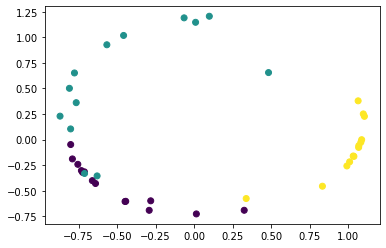

Epoch: 47/100: Loss: -13.215206146240234
Epoch: 48/100: Loss: -12.77903938293457
Epoch: 49/100: Loss: -12.743268013000488
Epoch: 50/100: Loss: -11.731484413146973
Epoch: 51/100: Loss: -11.751266479492188
LABEL: 1 - MEAN DST: 1.9368830919265747
LABEL: 2 - MEAN DST: 3.0062127113342285
LABEL: 3 - MEAN DST: 1.0740498304367065


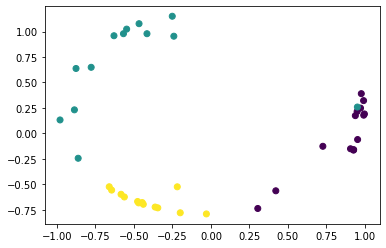

Epoch: 52/100: Loss: -13.295809268951416
Epoch: 53/100: Loss: -12.788300037384033
Epoch: 54/100: Loss: -12.821067810058594
Epoch: 55/100: Loss: -12.790882587432861
Epoch: 56/100: Loss: -13.274303913116455
LABEL: 1 - MEAN DST: 0.9339798092842102
LABEL: 2 - MEAN DST: 3.1804566383361816
LABEL: 3 - MEAN DST: 1.487160325050354


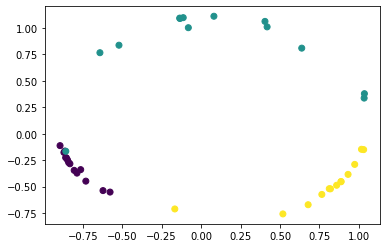

Epoch: 57/100: Loss: -12.379536628723145
Epoch: 58/100: Loss: -12.529460906982422
Epoch: 59/100: Loss: -13.964688301086426
Epoch: 60/100: Loss: -12.170267581939697
Epoch: 61/100: Loss: -12.45599365234375
LABEL: 1 - MEAN DST: 0.7585925459861755
LABEL: 2 - MEAN DST: 3.3399569988250732
LABEL: 3 - MEAN DST: 1.6664046049118042


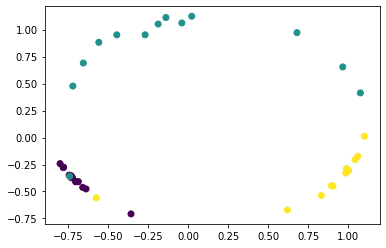

Epoch: 62/100: Loss: -12.221545696258545
Epoch: 63/100: Loss: -12.800615310668945
Epoch: 64/100: Loss: -12.495104789733887
Epoch: 65/100: Loss: -12.84016227722168
Epoch: 66/100: Loss: -12.131150722503662
LABEL: 1 - MEAN DST: 0.8613044619560242
LABEL: 2 - MEAN DST: 2.1561224460601807
LABEL: 3 - MEAN DST: 1.193564534187317


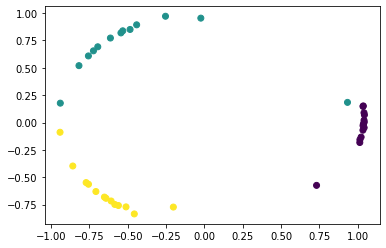

Epoch: 67/100: Loss: -13.43623161315918
Epoch: 68/100: Loss: -13.903485298156738
Epoch: 69/100: Loss: -12.53588056564331
Epoch: 70/100: Loss: -12.923761367797852
Epoch: 71/100: Loss: -12.354543209075928
LABEL: 1 - MEAN DST: 0.6987382769584656
LABEL: 2 - MEAN DST: 2.564262628555298
LABEL: 3 - MEAN DST: 2.1674160957336426


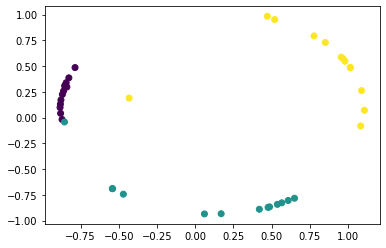

Epoch: 72/100: Loss: -12.911907196044922
Epoch: 73/100: Loss: -12.230163097381592
Epoch: 74/100: Loss: -13.278245449066162
Epoch: 75/100: Loss: -12.558290481567383
Epoch: 76/100: Loss: -12.39362621307373
LABEL: 1 - MEAN DST: 0.6522933840751648
LABEL: 2 - MEAN DST: 2.9782726764678955
LABEL: 3 - MEAN DST: 1.54915189743042


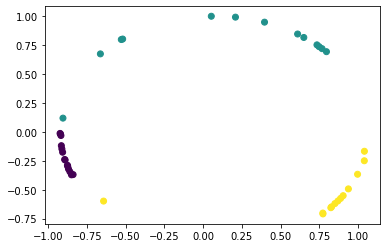

Epoch: 77/100: Loss: -13.54917573928833
Epoch: 78/100: Loss: -13.326476097106934
Epoch: 79/100: Loss: -14.017377376556396
Epoch: 80/100: Loss: -12.591863632202148
Epoch: 81/100: Loss: -12.856894493103027
LABEL: 1 - MEAN DST: 0.8252002000808716
LABEL: 2 - MEAN DST: 3.153641939163208
LABEL: 3 - MEAN DST: 1.2331068515777588


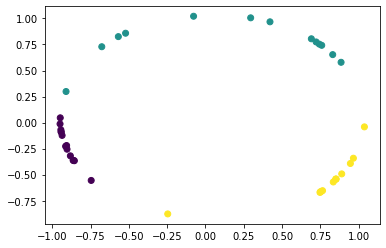

Epoch: 82/100: Loss: -13.588422775268555
Epoch: 83/100: Loss: -12.807299137115479
Epoch: 84/100: Loss: -12.77620553970337
Epoch: 85/100: Loss: -12.922343730926514
Epoch: 86/100: Loss: -12.578281879425049
LABEL: 1 - MEAN DST: 0.7985572814941406
LABEL: 2 - MEAN DST: 2.5775704383850098
LABEL: 3 - MEAN DST: 1.1513758897781372


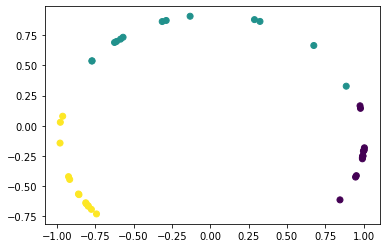

Epoch: 87/100: Loss: -12.548956871032715
Epoch: 88/100: Loss: -12.755454540252686
Epoch: 89/100: Loss: -12.463037490844727
Epoch: 90/100: Loss: -12.971871376037598
Epoch: 91/100: Loss: -12.68416452407837
LABEL: 1 - MEAN DST: 1.0791102647781372
LABEL: 2 - MEAN DST: 2.2607266902923584
LABEL: 3 - MEAN DST: 1.3779462575912476


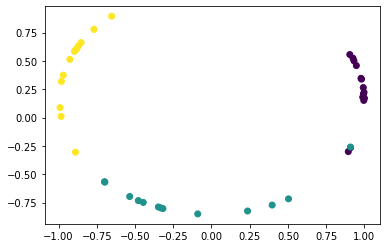

Epoch: 92/100: Loss: -12.49704885482788
Epoch: 93/100: Loss: -12.575899124145508
Epoch: 94/100: Loss: -12.815598487854004
Epoch: 95/100: Loss: -12.41312313079834
Epoch: 96/100: Loss: -12.78645658493042
LABEL: 1 - MEAN DST: 0.7555548548698425
LABEL: 2 - MEAN DST: 1.8647962808609009
LABEL: 3 - MEAN DST: 1.8657530546188354


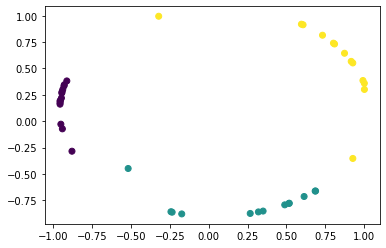

Epoch: 97/100: Loss: -12.948593139648438
Epoch: 98/100: Loss: -12.839394569396973
Epoch: 99/100: Loss: -13.34059476852417
Epoch: 100/100: Loss: -14.931126117706299


In [15]:
torch.cuda.empty_cache()
LOSS_COUNT_SAMPLES = 24

validate(model, val_dataset)
optimizer.zero_grad()
for epoch in range(EPOCHS):
    if epoch == 30:
        optimizer = torch.optim.Adam(model.parameters())
    losses = []
    all_labels = []
    all_ys = []
    for i, data in enumerate(train_loader, 0):
        torch.cuda.empty_cache()
        images, labels = data
        images = images.to(device=DEVICE)
        
        ys = model(images)
        
        all_ys.append(ys)
        all_labels.append(labels)
        
        if (i+1) % (LOSS_COUNT_SAMPLES // BATCH_SIZE) == 0:
            loss = loss_function(torch.cat(all_ys), torch.cat(all_labels))
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
            all_ys = []
            all_labels = []
            optimizer.zero_grad()
        
    total_loss = np.mean(losses)
    print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
    if epoch % 5 == 0:
        validate(model, val_dataset)
    
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE

In [16]:
# for epoch in range(EPOCHS):
#     if epoch == 3:
#         optimizer = torch.optim.Adam(model.get_backbone_params())
#     losses = []
#     for i, data in enumerate(train_loader, 0):
#         image_1, image_2, sign, weight = data
#         image_1 = image_1.to(device=DEVICE)
#         image_2 = image_2.to(device=DEVICE)
#         sign = sign.to(device=DEVICE)
#         weight = None # weight.to(device=DEVICE)

#         optimizer.zero_grad()
        
#         v_1 = model(image_1)
#         v_2 = model(image_2)
        
#         loss = loss_function(v_1, v_2, sign, weight=weight)
#         # loss2 = loss_function2(v_1, v_2, sign, weight=weight)
        
#         # print(sign)
#         # print(weight)
#         # print(loss2)
        
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.cpu().item())
#         if i % 10 == 0:
#             print(f"i: {i}: {loss}")
        
#     total_loss = np.mean(losses)
#     print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
#     validate(model, val_dataset)
#         # YOUR CODE HERE
        
#         # TODO: walidacja, wypisywanie lossów itd
#         # END YOUR CODE